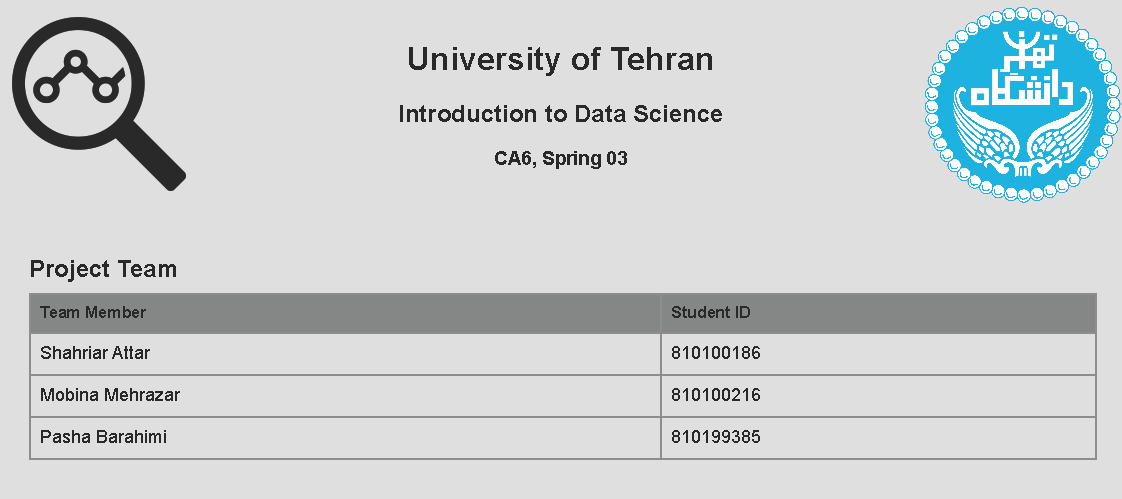

# Dimensionality Reduction and Unsupervised Learning

## Table of Contents

- [Introduction](#introduction)
- [Objectives](#objectives)
- [Tasks](#tasks)
- [Dataset Description](#dataset-description)
- [Environment Setup](#environment-setup)
- [Preprocessing](#preprocessing)
- [Dimensionality Reduction](#dimensionality-reduction)
- [Unsupervised Learning](#unsupervised-learning)
  - [Silhouette Method](#silhouette-method)
  - [K-Means](#k-means)
  - [DBSCAN](#dbscan)
- [Questions](#questions)
- [References](#references)

## Introduction

In this assignment, we will delve into dimensionality reduction and unsupervised learning tasks. Firstly, we should preprocess the provided dataset to prepare it for analysis. Next, we will apply dimensionality reduction techniques to simplify the dataset's complexity. Then, we will use unsupervised learning algorithms to tackle the task. Finally, we evaluate and analyze the results for comparison.

## Objectives

This assignment aims to:

- Implementing dimensionality reduction to simplify the dataset's complexity.
- Using unsupervised learning algorithms to tackle the task.

## Tasks

1. Preprocessing
2. Dimensionality Reduction
3. Unsupervised Learning
4. Evaluation and Analyzing the Results for Comparison

## Dataset Description

In 2014, some researchers published an article called "[Impact of c1HbA Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records.](https://www.hindawi.com/journals/bmri/2014/781670/)" They gathered data on diabetic patients from many hospitals and clinics in America. Some of this data, about 200,000 items with 50 features, has been shared with the public in a way that keeps people's identities private.

The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.

The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.


## Environment Setup

Let's begin with setting up the Python environment and importing the necessary libraries.

In [ ]:
import pandas as pd
import numpy as np

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from sklearnex import patch_sklearn, config_context

import pickle

In [ ]:
DIABETIC_DATA = "../data/diabetic_data.csv"

In [ ]:
patch_sklearn()

In [ ]:
df = pd.read_csv(DIABETIC_DATA)
df

## Preprocessing

Data Preprocessing or Data Preparation is a data mining technique that transforms raw data into an understandable format for ML algorithms. Real-world data is usually noisy (contains errors, outliers, duplicates), incomplete (some values are missed), and could be stored in different places and different formats. The task of Data Preprocessing is to handle these issues.

The dataset contains both numerical and textual values, along with outliers and null values. These inconsistencies can disrupt clustering accuracy. We'll normalize the data extensively and provide detailed explanations for each normalization step in the report file.

In [ ]:
# code

## Dimensionality Reduction

Some data mining algorithms, like K-Means, struggle with accurately clustering data when confronted with numerous features, leading to high dimensionality. This issue isn't exclusive to datasets with hundreds or thousands of features; even just ten features can pose accuracy challenges. Feature or dimensionality reduction aims to address this by transforming the original feature set into a smaller set of derived features that retain most of the original information.

Principal Component Analysis (PCA) is a widely used technique for feature reduction. It condenses the original dataset into a set number of features known as principal components. The desired number of principal components must be specified. In this section, we'll utilize PCA to reduce the dimensionality of the dataset. This approach is recommended if there are numerous variables, manual variable selection is impractical, or segmentation results are unsatisfactory.

In [1]:
# code

## Unsupervised Learning

### Silhouette Method

The Silhouette Method is a method to find the optimal number of clusters and interpretation and validation of consistency within clusters of data. The silhouette method computes silhouette coefficients of each point that measure how much a point is similar to its cluster compared to other clusters, by providing a succinct graphical representation of how well each object has been classified.

In [2]:
# code

### K-Means

K-Means Clustering is a type of Unsupervised Machine Learning algorithm that organizes an unlabeled dataset into distinct clusters. This method assigns data points to one of the K clusters based on their proximity to the cluster centers. Initially, cluster centroids are randomly placed in space. Then, each data point is assigned to the nearest cluster centroid. Subsequently, new cluster centroids are calculated. This iterative process continues until it converges on well-defined clusters.

In [ ]:
# code

### DBSCAN

DBSCAN is an unsupervised clustering algorithm, offering an alternative to KMeans and hierarchical clustering. It relies on two key parameters: Epsilon (ɛ), defining the neighborhood radius, and Minimum Points (minPts), specifying the minimum number of points to form a cluster. Epsilon determines the similarity threshold between points, influencing cluster size, while minPts affects cluster robustness and noise handling. Balancing these parameters is crucial for effective clustering without splitting valid clusters or aggregating unrelated points.

In [ ]:
# code

Utilizing the silhouette method, we'll determine the optimal number of clusters for the K-means method and the optimal input parameters (minPnt, eps) for the DBSCAN method. Based on the obtained values, we will then store the best result from each method in a CSV file containing only the columns: id_encounter, kmean_label, and dbscan_label.

## Questions

1. **What preprocessing steps did you perform on the dataset? Provide clear reasons for each decision made.**

2. **What portion of the dataset did you retain during dimensionality reduction, and which variables were retained? Could you elaborate on the rationale behind this decision?**

3. **Include a plot illustrating the silhouette coefficient plotted against the input parameters for each clustering method within the report file.**

4. **How can we determine the optimal number of clusters in K-Means?**

5. **How can we determine the optimal epsilon value and minPts in DBSCAN?**

6. **When would you recommend using K-Means, and when would you suggest using DBSCAN instead?**

## References

- [Dataset](https://www.hindawi.com/journals/bmri/2014/781670/)
- [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)
- [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [Silhouette Method](https://en.wikipedia.org/wiki/Silhouette_(clustering))
- [Silhouette Method](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)
- [K-Means](https://en.wikipedia.org/wiki/K-means_clustering)
- [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
- [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN)
- [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)
